In [285]:
import pandas as pd
import numpy as np
import random

# Load data
df = pd.read_csv("Madird_fixtures.csv")

df.shape


def fitness(schedule):
    score = 0
    consecutive_penalty = 1
    for i in range(len(schedule)):
        opponent_strength = df.loc[df["Opponent"] ==
                                   schedule[i], "Opponent Strength"].values[0]
        duration = df.loc[df["Opponent"] == schedule[i], "Duration"].values[0]
        if duration <= 0:
            # Ignore duration penalty for this game
            continue
        score += opponent_strength / duration
        if i > 0 and duration > 3 and opponent_strength > 9:
            last_opponent_strength = df.loc[df["Opponent"] ==schedule[i-1], "Opponent Strength"].values[0]
            last_duration = df.loc[df["Opponent"] ==schedule[i-1], "Duration"].values[0]
            if last_duration > 3 and last_opponent_strength > 9:
                consecutive_penalty *= 1
        # Update consecutive_penalty for next iteration
        else:
            consecutive_penalty = 1
    # Subtract penalties from the score
    score -= consecutive_penalty
    # Add a small random number to the score to make it unique
    score += random.uniform(0, 0.001)
    return score


def mutation(schedule, mutation_rate):
    mutated_schedule = schedule.copy()
    for i in range(len(schedule)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(schedule) -1)
            # Check if the mutation swaps two games with the same opponent
            if mutated_schedule[i] == mutated_schedule[j]:
                continue
            mutated_schedule[i], mutated_schedule[j] = mutated_schedule[j], mutated_schedule[i]
            # Check if the mutation violates the constraints
            opponent_strength = df.loc[df["Opponent"] == mutated_schedule[i], "Opponent Strength"].values[0]
            duration = df.loc[df["Opponent"] == mutated_schedule[i], "Duration"].values[0]
            if duration <= 0:
                # Ignore constraint for this game
                continue
            if i > 0:
                last_opponent_strength = df.loc[df["Opponent"] == mutated_schedule[i-1], "Opponent Strength"].values[0]
                last_duration = df.loc[df["Opponent"] == mutated_schedule[i-1], "Duration"].values[0]
                if mutated_schedule[i-1] == mutated_schedule[i] or (last_opponent_strength > 8 and opponent_strength > 9):
                    # Revert mutation if it violates the constraints
                    mutated_schedule[i], mutated_schedule[j] = mutated_schedule[j], mutated_schedule[i]
    return mutated_schedule


In [286]:
df.head()

,Competition,Date,place,Opponent,Opponent Strength,Duration,Transportation
0,La Liga,14/08/2021,away,CD Alavés,4.5,2,Plane
1,La Liga,22/08/2021,away,Levante UD,5.5,2,Plane
2,La Liga,28/08/2021,away,Real Betis,8.0,2,Plane
3,La Liga,12/09/2021,home,Celta Vigo,7.5,2,Plane
4,Champions League,15/09/2021,away,Inter,9.2,2,Plane


In [287]:
# Define parameters
population_size = 50
generations = 20
elite_size = 7
tournament_size = 7
mutation_rate = 0.1  # Define mutation rate here

# Initialize initial population
initial_population = []
for i in range(population_size):
    schedule = df["Opponent"].tolist()
    random.shuffle(schedule)  # Shuffle the list of opponents
    initial_population.append(schedule)

# Define a function to scale the fitness scores


def scale_fitness(fitness_scores):
    max_fitness = max(fitness_scores)
    return [100 * score / max_fitness for score in fitness_scores]


# Apply genetic algorithm
for generation in range(generations):
    fitness_scores = [fitness(schedule) for schedule in initial_population]
    # Replace NaN values with 0
    fitness_scores = np.nan_to_num(fitness_scores)
    # Scale fitness scores
    fitness_scores = scale_fitness(fitness_scores)
    sorted_population = [x for _, x in sorted(
        zip(fitness_scores, initial_population), key=lambda pair: pair[0], reverse=True)]
    elite = sorted_population[:elite_size]
    new_population = [elite[0]]
    while len(new_population) < population_size:
        # Tournament selection
        tournament = random.sample(sorted_population, tournament_size)
        parent1 = max(tournament, key=fitness)
        tournament.remove(parent1)
        parent2 = max(tournament, key=fitness)
        # Crossover
        crossover_point = random.randint(0, len(parent1))
        child = parent1[:crossover_point] + parent2[crossover_point:]
        child = mutation(child, mutation_rate)
        # Remove duplicates
        child_set = set()
        child_no_dup = []
        for x in child:
            if x not in child_set:
                child_no_dup.append(x)
                child_set.add(x)
        new_population.append(child_no_dup)
    initial_population = elite + new_population[elite_size:]
    # Update fitness scores
    fitness_scores = [fitness(schedule) for schedule in initial_population]
    # Replace NaN values with 0
    fitness_scores = np.nan_to_num(fitness_scores)
    # Scale fitness scores
    fitness_scores = scale_fitness(fitness_scores)
    sorted_population = initial_population  # Update sorted population
    print(fitness_scores)
    print("End of generation")

# Select the best schedule
fitness_scores = [fitness(schedule) for schedule in initial_population]
# Replace NaN values with 0
fitness_scores = np.nan_to_num(fitness_scores)
# Scale fitness scores
fitness_scores = scale_fitness(fitness_scores)
best_schedule_idx = np.argmax(fitness_scores)
best_schedule = initial_population[best_schedule_idx]
print("Best schedule:", best_schedule)


[99.9996706113043, 99.99978463690947, 100.0, 99.99982414683303, 99.99984192150934, 99.99956901227976, 99.99988157868201, 42.88475466395178, 46.536539299486776, 46.6074271640727, 41.57983946687501, 47.781469908917835, 47.781397368339526, 44.50923197651943, 46.60753554473879, 47.78124040195792, 46.60774814487306, 44.43745462451746, 44.37842888249597, 43.7266311866736, 46.60776463952869, 44.337159563415305, 42.30366049599248, 47.78129011051124, 41.76972869719025, 45.55263417938909, 45.504823929290986, 44.378391429841635, 47.7812413627578, 45.55205034686156, 47.781809901172814, 47.78128722797637, 40.88044170075844, 47.78170240100851, 42.61145555129488, 46.607465379323195, 45.55224542425076, 47.78178224053572, 47.78133662729685, 47.781509074998176, 47.78157911997595, 47.781372684049344, 47.78145582735965, 47.78130227743483, 47.78176067932212, 45.52833679445863, 47.78139314417953, 46.60796263706389, 43.32303003529318, 42.12541609569254]
End of generation
[99.99955160224474, 99.99973497235787

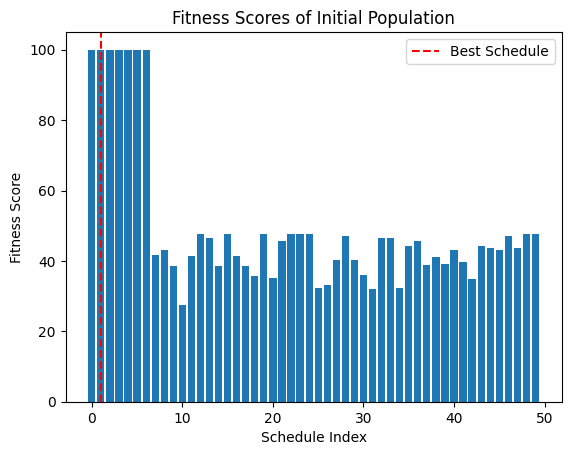

In [288]:
import matplotlib.pyplot as plt

# Create a bar chart
plt.bar(range(len(fitness_scores)), fitness_scores)
plt.xlabel('Schedule Index')
plt.ylabel('Fitness Score')
plt.title('Fitness Scores of Initial Population')

# Highlight the best schedule
plt.axvline(x=best_schedule_idx, color='red',
            linestyle='--', label='Best Schedule')
plt.legend()

# Display the graph
plt.show()


In [289]:
print(best_schedule)

['Athletic Bilbao', 'Manchester City', 'Rayo Vallecano', 'Villarreal CF', 'Cádiz CF', 'Elche CF', 'Sevilla FC', 'Athletic Bilbao', 'Espanyol Barcelona', 'Paris Saint-Germain', 'Levante UD', 'FC Barcelona', 'CA Osasuna', 'Real Betis', 'Real Sociedad', 'Elche CF', 'CA Osasuna', 'Real Betis', 'Atlético Madrid', 'Real Sociedad', 'Liverpool ', 'Athletic Bilbao', 'Cádiz CF', 'CD Alavés', 'FC Sheriff', 'Levante UD', 'Athletic Bilbao', 'CD Alcoyano', 'Valencia CF', 'Chelsea FC', 'Elche CF', 'FC Sheriff', 'Shakhtar Donetsk', 'Sevilla FC', 'Rayo Vallecano', 'Celta Vigo', 'Villarreal CF', 'Inter', 'Paris Saint-Germain', 'FC Barcelona', 'Celta Vigo', 'Atlético Madrid', 'RCD Mallorca', 'Chelsea FC', 'Granada CF', 'RCD Mallorca', 'Valencia CF', 'Granada CF', 'Getafe CF', 'CD Alavés', 'Shakhtar Donetsk', 'Manchester City', 'Inter', 'Espanyol Barcelona', 'Getafe CF', 'FC Barcelona']
